In [69]:
import wrds
db = wrds.Connection(wrds_username='yanvo')

Loading library list...
Done


## The Data extraction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

c:\Users\yanis\anaconda3\envs\ada\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Get the list of all the SIC codes

with open('Siccodes12.txt', 'r') as file:
    lines = file.readlines()

dic = {}

for j in range(0, 7000):
    dic[j] = 12
    sic = lines[0].strip().split(" ")[0]
    i = 1
    while i < len(lines)-2:
        if lines[i].strip() == "":
            sic = lines[i+1].strip().split(" ")[0]
            i += 2
            continue
        else:
            a = lines[i].strip().split("-")
            if j in range(int(a[0]), int(a[1])+1):
                dic[j] = sic
            i += 1

df = pd.DataFrame(dic.items(), columns=['SIC', 'FF_12'])

df.to_csv('48_Industries.csv', index=False)

In [187]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf = db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1964-01-01'
            and mcaldt<='2023-12-31'""", 
            date_cols=['mcaldt'])

Rf['tmytm'] = Rf['tmytm']/12/100
Rf = Rf.rename(columns={"mcaldt": "date", "tmytm": "rf"})

#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm = db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1964-01-01' and date<='2023-12-31'
                """, 
                date_cols=['date'])

Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd, b.siccd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1964' and '12/31/2023'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, 
                      date_cols=['date'])

stock_data = stock_data.drop(['shrcd', 'exchcd'], axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)

#---------------------------------------------
# Industry Definitions  and Returns 
#---------------------------------------------
Industry_Returns = pd.read_csv('12_Industry_Portfolios.txt', delimiter= '\s+', skiprows=11, nrows=1173, index_col=0)
Industry_Returns = Industry_Returns.loc['196401':'202312']
Industry_Returns.index = pd.to_datetime(Industry_Returns.index, format='%Y%m')
Industry_Definitions = pd.read_csv('48_Industries.csv')
Industry_Definitions = Industry_Definitions.rename(columns={'SIC':'siccd'})
Industries = Industry_Returns.columns.tolist()
Industry_Names = pd.DataFrame(Industries,index=np.arange(1,13)).reset_index()
Industry_Names.columns=['Industry','Name']
Industry_Returns = Industry_Returns.reset_index().rename(columns = {'index':'dateM'})
Industry_Returns['dateM'] = pd.to_datetime(Industry_Returns['dateM'], format='%Y%m', errors='coerce') + pd.offsets.MonthEnd(0)

#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data = pd.merge(data, Industry_Definitions[['siccd', 'FF_12']], on=['siccd'], how='left')
#data['dateM'] = data['date'].astype('datetime64[M]')
data['dateM'] = data['date']

data = pd.merge(data, Industry_Returns, on=['dateM'], how='left')
rf_array = np.array(data['rf'])
    
data[Industries] = data[Industries]/100 - rf_array[:,np.newaxis]

#---------------------------------------------
# Define Variables and drop obs
#---------------------------------------------
data = data.sort_values(['permno','date'])
data['mcap'] = np.abs(data['prc']) * data['shrout']
data['mcap_l'] = data.groupby(['permno'])['mcap'].shift(1)
data['Rn_f'] = data.groupby(['permno'])['Rn'].shift(-1)
data['const'] = 1
data['Rn_e'] = data['Rn'] - data['rf']
data['Rm_e'] = data['Rm'] - data['rf']
data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')
data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e', 'FF_12']).copy()

#---------------------------------------------
data.to_csv('data.csv', index=False)

In [4]:
data = pd.read_csv('data.csv', sep=",")
data['date'] = pd.to_datetime(data['date'])

In [5]:
data.shape

(1281568, 29)

In [6]:
data.sample(5)

,permno,date,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,...,Utils,Shops,Hlth,Money,Other,Rn_f,const,Rn_e,Rm_e,w_m
265241,23472,1976-05-28,3999,-0.027027,4453.0,4.500,20038.500,2.059512e+04,0.004217,-0.009326,...,NaN,NaN,NaN,NaN,NaN,0.000000,1,-0.031244,-0.013543,0.000028
472199,34681,1964-07-31,5641,0.047742,500.0,4.000,2000.000,1.937500e+03,0.002716,0.020118,...,0.046384,0.009384,0.044884,0.016384,0.005684,0.000000,1,0.045026,0.017402,0.000004
490985,35916,1970-11-30,5137,0.063726,1201.0,27.125,32577.125,3.062550e+04,0.003708,0.050449,...,0.090192,0.064992,0.025892,0.055792,0.015092,-0.096774,1,0.060018,0.046741,0.000056
834550,55730,1980-09-30,3841,-0.046753,3005.0,8.875,26669.375,2.892312e+04,0.008996,0.029498,...,-0.007496,0.003804,0.027204,0.017204,0.041704,0.028169,1,-0.055749,0.020502,0.000027
882885,59184,1989-11-30,2082,-0.030495,270404.0,36.500,9869746.000,1.024155e+07,0.005892,0.017816,...,0.026408,0.006608,0.039808,-0.011092,0.001308,0.054795,1,-0.036387,0.011924,0.003946


## Betting against Beta strategy

In [7]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

# 1. Remove stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date', 'permno'], how='left')

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05), data['beta'].quantile(0.95))

In [8]:
# 1. Quintiles
q = 10
data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, q, labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. Value Weighted Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
# TODO: Add risk free rate ???
vw_SR = vw_ret_mean / vw_ret_std * np.sqrt(12)

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()
# TODO: Add risk free rate ???
ew_SR = ew_ret_mean / ew_ret_std * np.sqrt(12)

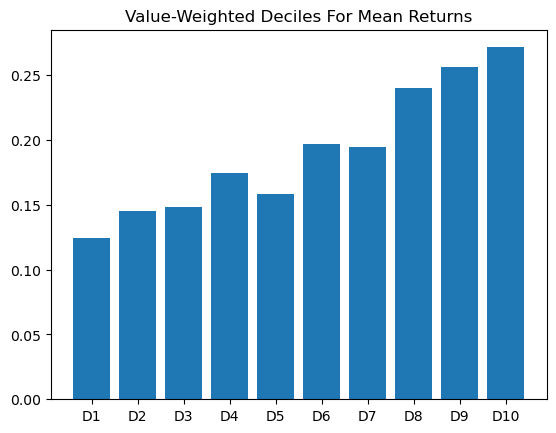

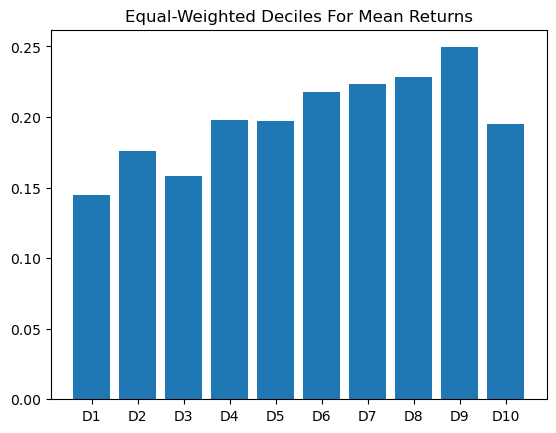

In [9]:
# 5. Plot Histogram for Mean Returns
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_ret_mean * 12)
plt.title('Value-Weighted Deciles For Mean Returns')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_ret_mean * 12),
plt.title('Equal-Weighted Deciles For Mean Returns')
plt.show()

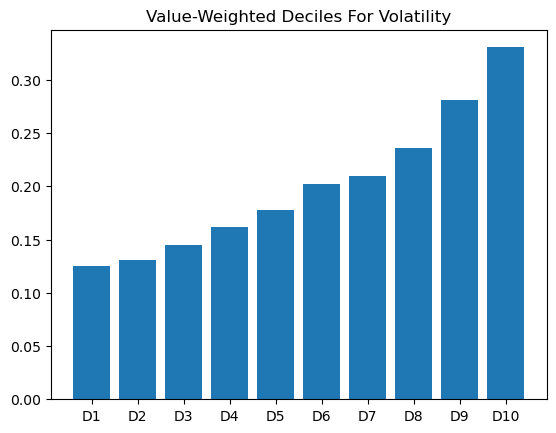

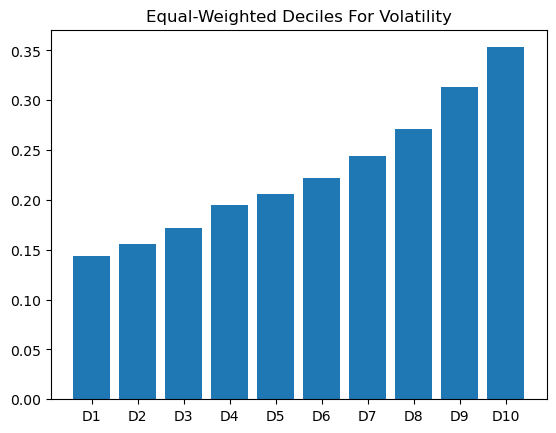

In [10]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles For Volatility')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles For Volatility')
plt.show()

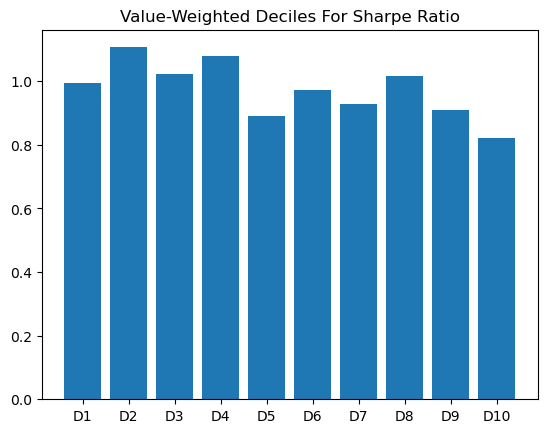

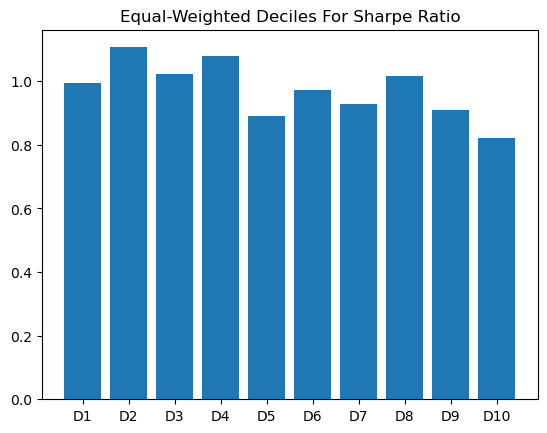

In [11]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_SR)
plt.title('Value-Weighted Deciles For Sharpe Ratio')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_SR),
plt.title('Equal-Weighted Deciles For Sharpe Ratio')
plt.show()

# TODO: Summarize our findings.  Is the evidence consistentwith the CAPM?

Value Weighted Portfolio: .

Equal Weighted Portfolio: .

In [142]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)
data['w_BAB'] = data['w_L'] - data['w_H']

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H', 'R_L', 'R_H_e', 'R_L_e', 'beta_H', 'beta_L']].sum().reset_index()

# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']

In [139]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB, data[['date', 'Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0] * 12
idio_vol = (tmp['BAB2'] - OLS_Reg.predict()).std() * np.sqrt(12)
market_rp = tmp['Rm_e'].mean() * 12
market_vol = tmp['Rm_e'].std() * np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor:', Alpha_bab, "t-stat:", OLS_Reg.tvalues[0])
print('Mean of BAB factor:', tmp['BAB2'].mean() * 12)
print('Volatility of BAB factor:', tmp['BAB2'].std() * np.sqrt(12))
print('Sharpe Ratio of BAB factor:', tmp['BAB2'].mean()/tmp['BAB2'].std() * np.sqrt(12))
#print('Idiosyncatic volatility:', idio_vol)
#print('Beta BAB:', beta_bab)
#print('Market Risk Premium:', market_rp)
#print('Market Volatility:', market_vol)

Annualized Alpha of BAB factor: 0.06683019184882398 t-stat: 2.558994731390483
Mean of BAB factor: 0.10571367143001861
Volatility of BAB factor: 0.14348370946603067
Sharpe Ratio of BAB factor: 0.7367642767491035
Idiosyncatic volatility: 0.11693764253222343
Beta BAB: 0.4939220303203245
Market Risk Premium: 0.07872392238908113
Market Volatility: 0.16833715761798662


## Momentum Strategy (Mom)

In [14]:
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn + 1).rolling(11, closed='left').sum()).values

In [15]:
q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x, q, labels=False, duplicates='drop'))

In [16]:
# 2. Market Weights within quintiles
data['vw_mom_Q'] = data['mcap'] / data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. Value Weighted Portfolios
data['mom_ret_vw'] = data['vw_mom_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'Momentum'])['mom_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['mom_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('Momentum')['mom_ret_vw'].std()
# TODO: Add risk free rate ???
vw_SR = vw_ret_mean / vw_ret_std * np.sqrt(12)

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()
# TODO: Add risk free rate ???
ew_SR = ew_ret_mean / ew_ret_std * np.sqrt(12)

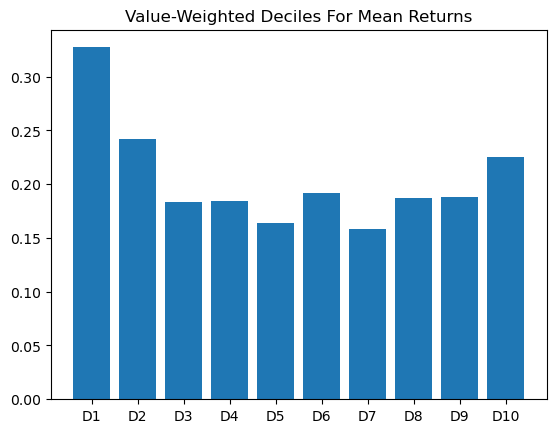

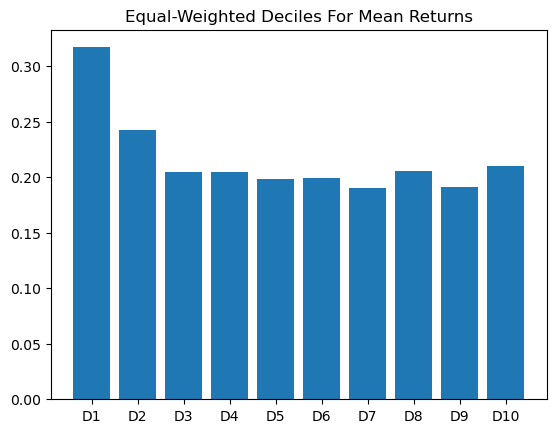

In [17]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_ret_mean * 12)
plt.title('Value-Weighted Deciles For Mean Returns')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles For Mean Returns')
plt.show()

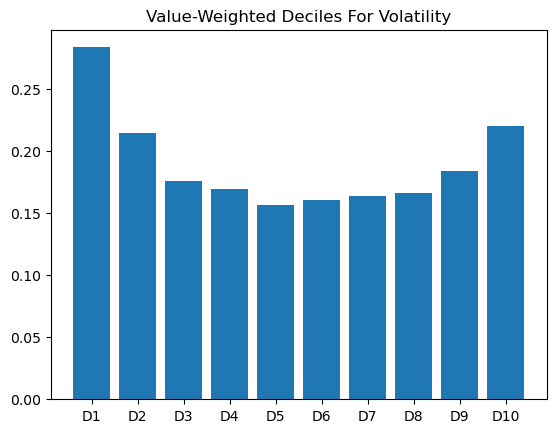

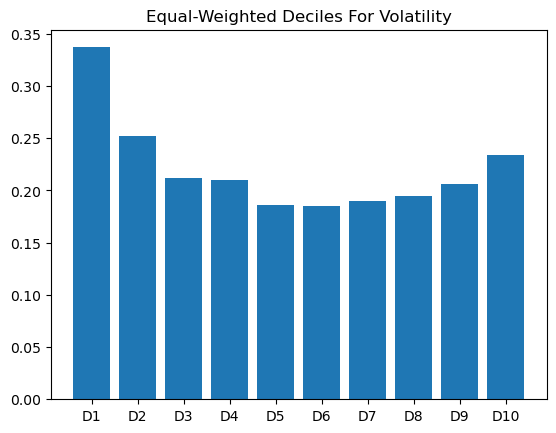

In [18]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles For Volatility')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles For Volatility')
plt.show()

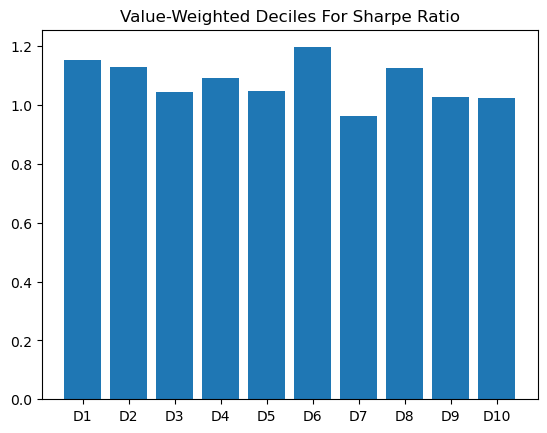

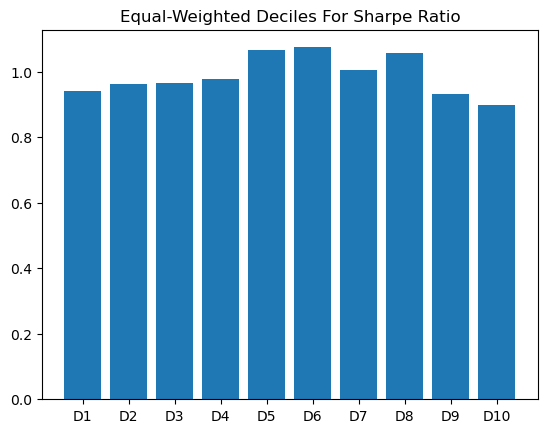

In [19]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_SR)
plt.title('Value-Weighted Deciles For Sharpe Ratio')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_SR)
plt.title('Equal-Weighted Deciles For Sharpe Ratio')
plt.show()

# TODO: Is the evidence consistent with the CAPM?

Value Weighted Portfolio: .

Equal Weighted Portfolio: .

In [51]:
data['w_L'] = data['Momentum'].isin([q - 1, q - 2, q - 3]) * data['mcap']
data['w_S'] = data['Momentum'].isin([0, 1, 2]) * data['mcap']
data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
data['w_Mom'] = data['w_L'] - data['w_S']
Momentum = data.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_Mom'])).reset_index()
Momentum['date'] =  Momentum['date'] + pd.DateOffset(months=1)
Momentum.columns = ['date','Mom_ret']

In [21]:
data['S_ret'] = data['Rn_f'] * data['w_S']

S_ret = data.groupby('date').apply(lambda x: np.sum(x['S_ret'])).reset_index()
S_ret_mean = S_ret[0].mean()
S_ret_std = S_ret[0].std()
S_SR = S_ret_mean / S_ret_std * np.sqrt(12)

print('Mean of S factor:', S_ret_mean * 12)
print('Volatility of S factor:', S_ret_std * np.sqrt(12))
print('Sharpe Ratio of S factor:', S_SR)

Mean of S factor: 0.15768969789845252
Volatility of S factor: 0.16290160363526782
Sharpe Ratio of S factor: 0.9680058046053087


In [22]:
data['L_ret'] = data['Rn_f'] * data['w_L']

L_ret = data.groupby('date').apply(lambda x: np.sum(x['L_ret'])).reset_index()
L_ret_mean = L_ret[0].mean()
L_ret_std = L_ret[0].std()
L_SR = L_ret_mean / L_ret_std * np.sqrt(12)

print('Mean of L factor:', L_ret_mean * 12)
print('Volatility of L factor:', L_ret_std * np.sqrt(12))
print('Sharpe Ratio of L factor:', L_SR)

Mean of L factor: 0.15139268634205366
Volatility of L factor: 0.16703906811118385
Sharpe Ratio of L factor: 0.9063310042012702


In [23]:
data['Mom_ret'] = data['Rn_f'] * data['w_Mom']

Mom_ret = data.groupby('date').apply(lambda x: np.sum(x['Mom_ret'])).reset_index()
Mom_ret_mean = Mom_ret[0].mean()
Mom_ret_std = Mom_ret[0].std()
Mom_SR = Mom_ret_mean / Mom_ret_std * np.sqrt(12)

print('Mean of Mom factor:', Mom_ret_mean * 12)
print('Volatility of Mom factor:', Mom_ret_std * np.sqrt(12))
print('Sharpe Ratio of Mom factor:', Mom_SR)

Mean of Mom factor: -0.00629701155639888
Volatility of Mom factor: 0.10525724283985162
Sharpe Ratio of Mom factor: -0.05982497153169547


In [24]:
# Perform t-test
t_statistic, p_value = ttest_ind(Mom_ret_mean, 0)

if p_value < 0.05:
    print("The strategy has an average return that is statistically significantly different from zero.")
else:
    print("The strategy does not have an average return that is statistically significantly different from zero.")

The strategy does not have an average return that is statistically significantly different from zero.


In [25]:
# TODO: Repeat both tests for equal and value-weightedportfolios


## Idiosyncratic Volatility Strategy (IV)

In [26]:
# Step 1: Ensure at least 36 months of observations for each stock
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N'] >= 36].copy()

In [28]:
idiosyncratic_volatility = {}

for permno, group in data.groupby('permno'):
    rolling_data = group.set_index('date')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36)
    dic = {}
    for window in rolling_data:
        X = sm.add_constant(window[['Rm_e']])
        y = window['Rn_e']
        model = sm.OLS(y, X)
        results = model.fit()
        fitted_values = results.predict(X)
        idio_vol = (y - fitted_values).std()*np.sqrt(12)
        date = window.iloc[-1].name
        dic[date] = idio_vol 
    idiosyncratic_volatility[permno] = dic

In [29]:
# transform the dictionary into a DataFrame
idio_vol_df = pd.DataFrame(idiosyncratic_volatility).T.stack().reset_index().rename(columns={'level_0':'permno', 'level_1':'date', 0:'idio_vol'})
# export the DataFrame to a csv file
idio_vol_df.to_csv('idio_volatility.csv', index=False)

In [32]:
idio_vol_df = pd.read_csv('idio_volatility.csv')
idio_vol_df['date'] = pd.to_datetime(idio_vol_df['date'])

In [33]:
#merge idio_vol_df with data
data = pd.merge(data, idio_vol_df, on=['date', 'permno'], how='left')

# Step 3: Winsorize the volatility at 5th and 95th percentiles
data['idio_vol'] = data['idio_vol'].clip(data['idio_vol'].quantile(0.05), data['idio_vol'].quantile(0.95))

In [34]:
q = 10
data['idio_vol_Q'] = data.groupby('date')['idio_vol'].transform(lambda x: pd.qcut(x, q, labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
data['vw_idio_vol_Q'] = data['mcap'] / data.groupby(['date', 'idio_vol_Q'])['mcap'].transform('sum')

# 3. Value Weighted Portfolios
data['idio_vol_ret_vw'] = data['vw_idio_vol_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'idio_vol_Q'])['idio_vol_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('idio_vol_Q')['idio_vol_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('idio_vol_Q')['idio_vol_ret_vw'].std()
# TODO: Add risk free rate ???
vw_SR = vw_ret_mean / vw_ret_std * np.sqrt(12)

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'idio_vol_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('idio_vol_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('idio_vol_Q')['Rn'].std()
# TODO: Add risk free rate ???
ew_SR = ew_ret_mean / ew_ret_std * np.sqrt(12)

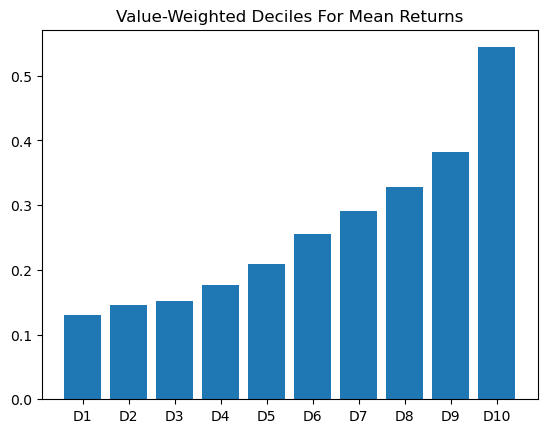

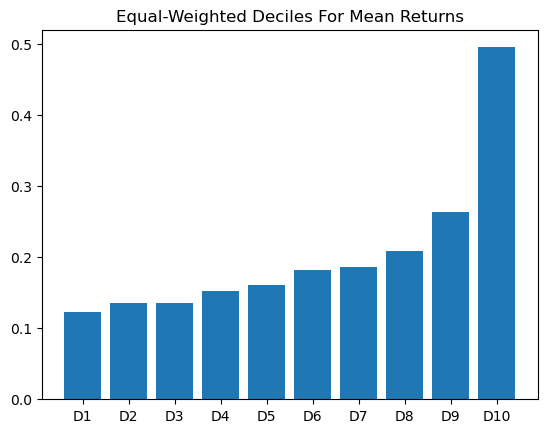

In [35]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_ret_mean * 12)
plt.title('Value-Weighted Deciles For Mean Returns')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles For Mean Returns')
plt.show()

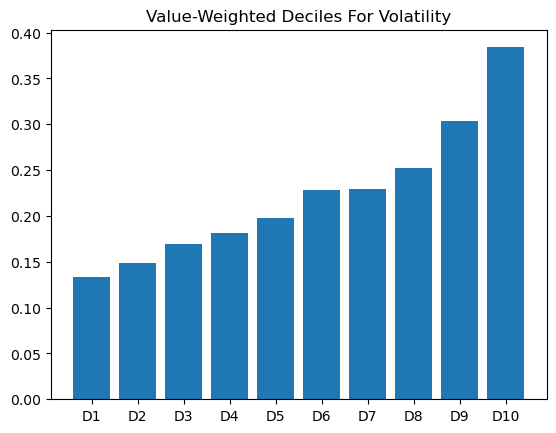

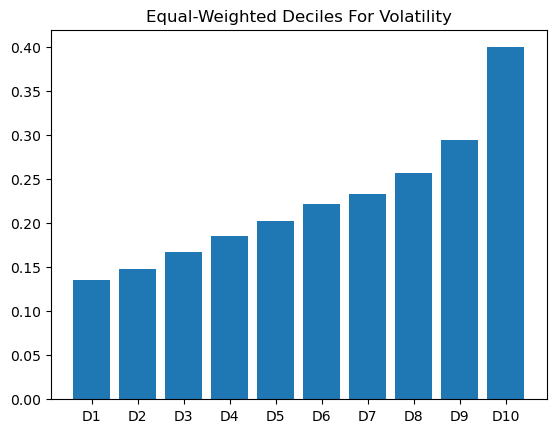

In [36]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles For Volatility')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles For Volatility')
plt.show()

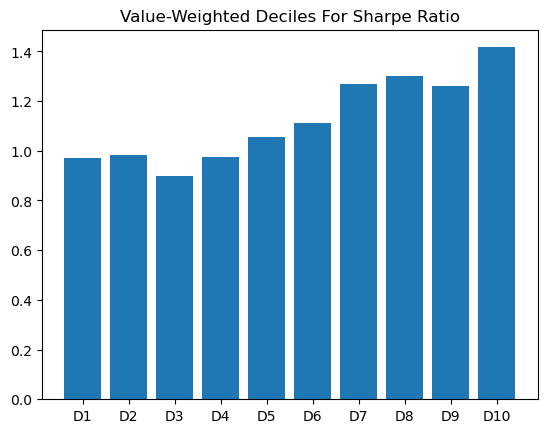

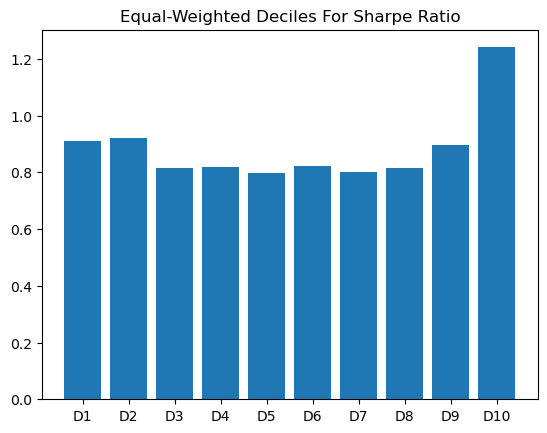

In [37]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1,11)], vw_SR)
plt.title('Value-Weighted Deciles For Sharpe Ratio')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1,11)], ew_SR)
plt.title('Equal-Weighted Deciles For Sharpe Ratio')
plt.show()

# TODO: Is the evidence consistent with the CAPM?

Value Weighted Portfolio: .

Equal Weighted Portfolio: .

In [56]:
data['w_L_idio_vol'] = data['idio_vol_Q'].isin([q - 1, q - 2, q - 3]) * data['mcap']
data['w_S_idio_vol'] = data['idio_vol_Q'].isin([0, 1, 2]) * data['mcap']
data['w_L_idio_vol'] = data['w_L_idio_vol']/data.groupby(['date'])['w_L_idio_vol'].transform('sum')
data['w_S_idio_vol'] = data['w_S_idio_vol']/data.groupby(['date'])['w_S_idio_vol'].transform('sum')
data['w_idio_vol'] = data['w_L_idio_vol'] - data['w_S_idio_vol']
IdioVol = data.groupby('date').apply(lambda x: np.sum(x['Rn_f'] * x['w_idio_vol'])).reset_index()
IdioVol['date'] =  IdioVol['date'] + pd.DateOffset(months=1)
IdioVol.columns = ['date', 'Idio_vol_ret']

In [39]:
data['S_ret_idio_vol'] = data['Rn_f'] * data['w_S_idio_vol']

S_ret = data.groupby('date').apply(lambda x: np.sum(x['S_ret_idio_vol'])).reset_index()
S_ret_mean = S_ret[0].mean()
S_ret_std = S_ret[0].std()
S_SR = S_ret_mean / S_ret_std * np.sqrt(12)

print('Mean of S factor:', S_ret_mean * 12)
print('Volatility of S factor:', S_ret_std * np.sqrt(12))
print('Sharpe Ratio of S factor:', S_SR)

Mean of S factor: 0.15072846894714362
Volatility of S factor: 0.1379502645478513
Sharpe Ratio of S factor: 1.092629067738104


In [40]:
data['L_ret_idio_vol'] = data['Rn_f'] * data['w_L_idio_vol']

L_ret = data.groupby('date').apply(lambda x: np.sum(x['L_ret_idio_vol'])).reset_index()
L_ret_mean = L_ret[0].mean()
L_ret_std = L_ret[0].std()
L_SR = L_ret_mean / L_ret_std * np.sqrt(12)

print('Mean of L factor:', L_ret_mean * 12)
print('Volatility of L factor:', L_ret_std * np.sqrt(12))
print('Sharpe Ratio of L factor:', L_SR)

Mean of L factor: 0.17334248610195355
Volatility of L factor: 0.23080949357405997
Sharpe Ratio of L factor: 0.751019741076348


In [41]:
data['idio_vol_ret'] = data['Rn_f'] * data['w_idio_vol']

Idio_vol_ret = data.groupby('date').apply(lambda x: np.sum(x['idio_vol_ret'])).reset_index()
Idio_vol_ret_mean = Idio_vol_ret[0].mean()
Idio_vol_ret_std = Idio_vol_ret[0].std()
Idio_vol_SR = Idio_vol_ret_mean / Idio_vol_ret_std * np.sqrt(12)

print('Mean of Idiosyncratic Volatility factor:', Idio_vol_ret_mean * 12)
print('Volatility of Idiosyncratic Volatility factor:', Idio_vol_ret_std * np.sqrt(12))
print('Sharpe Ratio of Idiosyncratic Volatility factor:', Idio_vol_SR)

Mean of Idiosyncratic Volatility factor: 0.02591875495390622
Volatility of Idiosyncratic Volatility factor: 0.1561021273030523
Sharpe Ratio of Idiosyncratic Volatility factor: 0.16603716683237935


In [42]:
# Perform t-test
t_statistic, p_value = ttest_ind(Idio_vol_ret_mean, 0)

if p_value < 0.05:
    print("The strategy has an average return that is statistically significantly different from zero.")
else:
    print("The strategy does not have an average return that is statistically significantly different from zero.")

The strategy does not have an average return that is statistically significantly different from zero.


In [43]:
# TODO: Repeat both tests for equal and value-weightedportfolios


# TODO: How do your results differ from Ang, Hodrick, Xing, and Zhang (2006; table VI page 285) and what may be the explanation for the difference?

## Optimal Fund Portfolio Return (STRAT)

In [91]:
STRAT = pd.merge(Momentum, IdioVol, on=['date'], how='left')
STRAT = pd.merge(STRAT, BAB, on=['date'], how='left')
STRAT = STRAT[['date', 'Mom_ret', 'Idio_vol_ret', 'BAB2']]
STRAT['year'] = STRAT['date'].dt.year

target_vol = 0.1

### Equal weight the strategies

In [92]:
# compute equal weighted returns
STRAT['ew_strat_ret'] = (STRAT['Mom_ret'] + STRAT['Idio_vol_ret'] + STRAT['BAB2']) / 3

# compute the average annual volatility for the equal weighted strategy
ew_start_vol = STRAT['ew_strat_ret'].groupby(STRAT['year']).std().mean() * np.sqrt(12)
ew_c = np.sqrt(target_vol**2 / ew_start_vol**2)

print(ew_c)

1.3426454315999532


In [93]:
FUND = pd.merge(STRAT, Rf, on=['date'], how='left')
FUND['ew_fund_ret'] = FUND['rf'] + ew_c * FUND['ew_strat_ret']

In [94]:
ew_fund_ret_mean = FUND['ew_fund_ret'].mean()
ew_fund_ret_std = FUND['ew_fund_ret'].std()
ew_fund_SR = ew_fund_ret_mean / ew_fund_ret_std * np.sqrt(12)

In [95]:
print('Mean of equal-weighted strategy fund:', ew_fund_ret_mean * 12)
print('Volatility of equal-weighted strategy fund:', ew_fund_ret_std * np.sqrt(12))
print('Sharpe Ratio of equal-weighted strategy fund:', ew_fund_SR)

Mean of equal-weighted strategy fund: 0.18661185964095636
Volatility of equal-weighted strategy fund: 0.11501320798253464
Sharpe Ratio of equal-weighted strategy fund: 1.6225254726334937


### Risk-Parity based on the rolling window estimate of the strategy returns volatilities

In [103]:
bab_ret_vol = STRAT['BAB2'].std() * np.sqrt(12)
momentum_ret_vol = STRAT['Mom_ret'].std() * np.sqrt(12)
idio_vol_ret_vol = STRAT['Idio_vol_ret'].std() * np.sqrt(12)

rp_w_bab = 1/bab_ret_vol / (1/momentum_ret_vol + 1/idio_vol_ret_vol + 1/bab_ret_vol)
rp_w_momentum = 1/momentum_ret_vol / (1/momentum_ret_vol + 1/idio_vol_ret_vol + 1/bab_ret_vol)
rp_w_idio_vol = 1/idio_vol_ret_vol / (1/momentum_ret_vol + 1/idio_vol_ret_vol + 1/bab_ret_vol)

STRAT['rp_strat_ret'] = rp_w_bab * STRAT['BAB2'] + rp_w_momentum * STRAT['Mom_ret'] + rp_w_idio_vol * STRAT['Idio_vol_ret']

# compute the average annual volatility for the equal weighted strategy
rp_start_vol = STRAT['rp_strat_ret'].groupby(STRAT['year']).std().mean() * np.sqrt(12)
rp_c = np.sqrt(target_vol**2 / ew_start_vol**2)

print(rp_c)

1.3426454315999532


In [104]:
FUND = pd.merge(FUND, STRAT[['date', 'rp_strat_ret']], on=['date'], how='left')
FUND['rp_fund_ret'] = FUND['rf'] + rp_c * FUND['rp_strat_ret']

In [105]:
rp_fund_ret_mean = FUND['rp_fund_ret'].mean()
rp_fund_ret_std = FUND['rp_fund_ret'].std()
rp_fund_SR = rp_fund_ret_mean / rp_fund_ret_std * np.sqrt(12)

In [106]:
print('Mean of risk-parity strategy fund:', rp_fund_ret_mean * 12)
print('Volatility of risk-parity strategy fund:', rp_fund_ret_std * np.sqrt(12))
print('Sharpe Ratio of risk-parity strategy fund:', rp_fund_SR)

Mean of risk-parity strategy fund: 0.17585937007458882
Volatility of risk-parity strategy fund: 0.10630435412054466
Sharpe Ratio of risk-parity strategy fund: 1.6543007248336385


In [144]:
data['w_strat'] = data['w_BAB'] * rp_w_bab + data['w_Mom'] * rp_w_momentum + data['w_idio_vol'] * rp_w_idio_vol

### Mean-variance optimal combination based on the rolling window mean and covariance matrix of the strategy returns

## Performance and risk analysis for the Fund strategy

### Performance against the industry portfolio

In [111]:
Industries = [
    'NoDur',
    'Durbl',
    'Manuf',
    'Enrgy',
    'Chems',
    'BusEq',
    'Telcm',
    'Utils',
    'Shops',
    'Hlth',
    'Money',
    'Other'
    ]

# Merge
tmp = pd.merge(FUND, data[['date', 'Rm_e'] + Industries].drop_duplicates(), on='date', how='left')
tmp['const'] = 1
tmp = tmp.dropna()

# Industry Exposure
RegOLS = sm.OLS(tmp['rp_fund_ret'], tmp[['const','Rm_e'] + Industries]).fit()
print(pd.concat([RegOLS.params, RegOLS.tvalues], axis=1).rename(columns={0:'Coef', 1:'t-stat'}))
print("R²:", RegOLS.rsquared)

           Coef    t-stat
const  0.003159  0.842293
Rm_e   1.657182  4.541413
NoDur  0.215780  1.016067
Durbl -0.222575 -2.308283
Manuf  0.189179  0.655305
Enrgy -0.001539 -0.026524
Chems -0.328567 -1.724333
BusEq -0.308620 -2.444059
Telcm -0.261801 -2.202877
Utils -0.079925 -0.697191
Shops  0.138679  0.722938
Hlth  -0.210429 -2.122061
Money -0.239666 -1.442165
Other -0.108517 -0.489997
R²: 0.7011500947271163


### Performance against the Fama-French 5 factors

In [120]:
#read fama french data
FF = pd.read_csv('F-F_5.csv', sep=",", skiprows=3, index_col=0)
FF = FF.loc['196401':'202312']
FF.index = pd.to_datetime(FF.index, format='%Y%m')
FF = FF.astype(float)
FF['year'] = FF.index.year
FF['month'] = FF.index.month

FUND['year'] = FUND['date'].dt.year
FUND['month'] = FUND['date'].dt.month

# regress the momentum returns on the Fama-French factors
tmp = pd.merge(FUND, FF, on=['year', 'month'], how='left')
tmp = tmp.dropna()
tmp['const'] = 1

RegOLS = sm.OLS(tmp['rp_fund_ret'], tmp[['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]).fit()
print(pd.concat([RegOLS.params, RegOLS.tvalues], axis=1).rename(columns={0:'Coef', 1:'t-stat'}))
print("R²:", RegOLS.rsquared)

            Coef    t-stat
const   0.006552  2.420272
Mkt-RF  0.002954  5.283059
SMB     0.004735  4.395238
HML    -0.000713 -0.497209
RMW     0.001525  1.289754
CMA     0.001533  0.780690
R²: 0.5652856963825502


In [127]:
data.columns

Index(['permno', 'date', 'siccd', 'Rn', 'shrout', 'prc', 'mcap', 'mcap_l',
       'rf', 'Rm', 'FF_12', 'dateM', 'NoDur', 'Durbl', 'Manuf', 'Enrgy',
       'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other',
       'Rn_f', 'const', 'Rn_e', 'Rm_e', 'w_m', 'N', 'beta', 'beta_Q', 'vw_Q',
       'beta_ret_vw', 'z', 'z_', 'k', 'w_H', 'w_L', 'beta_H', 'beta_L', 'R_H',
       'R_L', 'R_H_e', 'R_L_e', 'LN_Cret12', 'Momentum', 'vw_mom_Q',
       'mom_ret_vw', 'w_S', 'w_Mom', 'S_ret', 'L_ret', 'Mom_ret', 'idio_vol',
       'idio_vol_Q', 'vw_idio_vol_Q', 'idio_vol_ret_vw', 'w_L_idio_vol',
       'w_S_idio_vol', 'w_idio_vol', 'S_ret_idio_vol', 'L_ret_idio_vol',
       'idio_vol_ret'],
      dtype='object')

In [131]:
# Compute market beta for each stock
Parameters = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'], x[['const', 'Rm_e']]).fit().params).reset_index()
Parameters.columns=['permno', 'alpha', 'beta_Mkt']
tmp = pd.merge(data[['date', 'permno', 'w_strat', 'Rn_e', 'FF_12']], Parameters[['permno', 'beta_Mkt']], on=['permno'], how='left')
tmp['beta_Mkt'] = tmp['beta_Mkt'].clip(-2, 2)

# Industry Exposures as Dummy
tmp[Industries] = pd.get_dummies(tmp['FF_12']).replace({True: 1, False: 0})

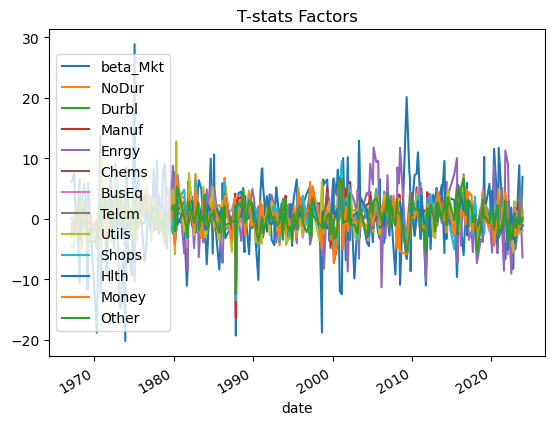

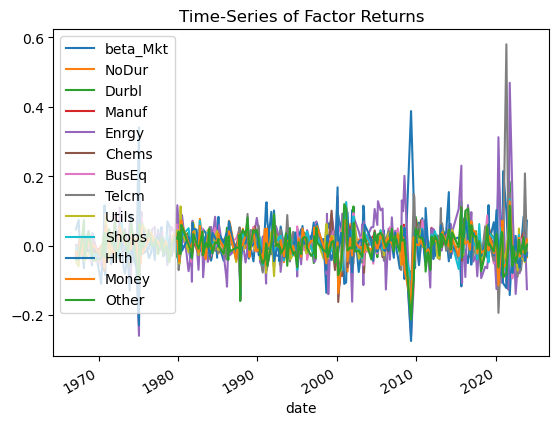

          Mean T-stats  Mean Abs T-stats
beta_Mkt      0.346350          4.827743
NoDur         0.323005          1.841895
Durbl         0.201581          1.494782
Manuf         0.430925          2.155717
Enrgy         0.609446          3.395314
Chems         0.254330          1.620890
BusEq         0.325842          1.640469
Telcm         0.213817          1.210590
Utils         0.375957          2.458410
Shops         0.392220          1.825769
Hlth          0.244591          1.645193
Money         0.286624          2.028475
Other         0.304820          1.924955


In [129]:
# Estimate Factor
Factors = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'], x[['beta_Mkt'] + Industries]).fit().params)

Factors_tstats = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'], x[['beta_Mkt'] + Industries]).fit().tvalues)

# Plot T-stats
Factors_tstats.plot()
plt.title('T-stats Factors')
plt.show()
Factors.plot()
plt.title('Time-Series of Factor Returns')
plt.show()
print(pd.concat([Factors_tstats.mean(), np.abs(Factors_tstats).mean()], axis=1).rename(columns={0:'Mean T-stats', 1:'Mean Abs T-stats'}))

In [130]:
Exposures = tmp[['date', 'w_Mom', 'beta_Mkt'] + Industries].copy()
Exposures[Industries] = Exposures[Industries] * Exposures['w_Mom'].to_numpy()[:, np.newaxis]
Exposures['beta_Mkt'] = Exposures['w_Mom'] * Exposures['beta_Mkt']
Exposures = Exposures.groupby('date')[['beta_Mkt'] + Industries].sum()

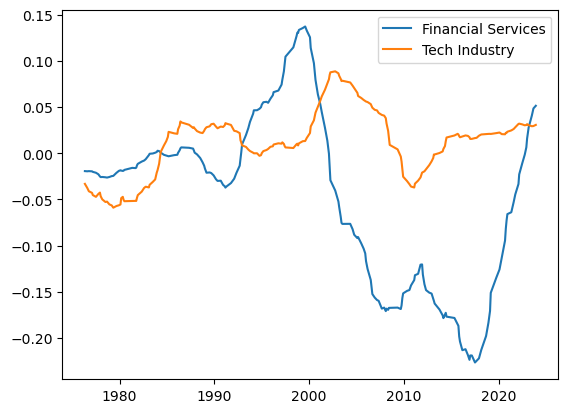

In [125]:
# Plot Exposure to all industries
''' plt.plot(Exposures)
plt.legend(Exposures.columns)
plt.show()'''


# Plot Exposure to Tech and Finance
plt.plot(Exposures['Money'].rolling(36).mean())
plt.plot(Exposures['BusEq'].rolling(36).mean())
plt.legend(['Financial Services', 'Tech Industry'])
plt.show()

In [126]:
# Hedge Portfolio Return
Hedge_Return = Factors * Exposures.rename(columns={'beta_Mkt':'Rm_e'})
Hedge_Return = Hedge_Return.sum(axis=1)

Mom_hedge = Momentum.set_index('date') - Hedge_Return.to_numpy()[:, np.newaxis]
print('Momentum-Hedged Return:', Mom_hedge.mean() * 12)
print('Momentum-Hedged Volatility:', Mom_hedge.std() * np.sqrt(12))
print('Momentum-Hedged Sharpe Ratio:', Mom_hedge.mean()/Mom_hedge.std() * np.sqrt(12))

Momentum-Hedged Return:  Mom_ret   -0.006836
dtype: float64
Momentum-Hedged Std:  Mom_ret    0.135733
dtype: float64
Momentum-Hedged Sharpe:  Mom_ret   -0.050367
dtype: float64


## Industry neutral strategy

In [ ]:
# regress the industy neutral strategy returns on industy factors and the Fama-French factors
Indus_FF = pd.merge(data[['date', 'Rm_e'] + Industries].drop_duplicates(), FF, left_on='date', right_index=True, how='left')
tmp = pd.merge(Momentum, Indus_FF, left_on='date', right_index=True, how='left')
tmp = tmp.dropna()
tmp['const'] = 1

RegOLS = sm.OLS(tmp['Mom_ret'], tmp[['const','Mkt-RF','SMB','HML','RMW','CMA']]).fit()
print(pd.concat([RegOLS.params,RegOLS.tvalues], axis=1))
print("R²:", RegOLS.rsquared)